Adım 1: Kütüphaneler ve önceden eğitilmiş ResNet50 modeli yükleniyor...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\emirhan55/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100.0%


Model başarıyla yüklendi ve değerlendirme moduna alındı.

Adım 2 & 3: Ön işleme adımları ve sınıf etiketleri hazırlanıyor...
Hazırlıklar tamamlandı.

Adım 4: Görüntü analizi başlıyor...
Analiz edilecek resim: https://www.gap.com/webcontent/0053/923/678/cn53923678.jpg
Analiz tamamlandı.

--- SONUÇLAR ---
Tespit Edilen Kategori: GOWN
Modelin Güven Skoru: 11.70%


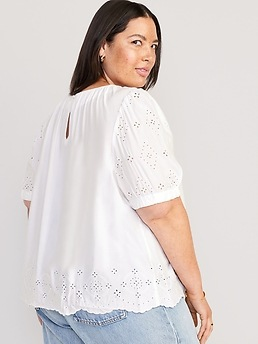

In [1]:
# ==============================================================================
# AURA AI ENGINE - MODÜL 1: GÖRÜNTÜ ANALİZİ PROTOTİPİ
# ==============================================================================
# AMAÇ: Verilen bir kıyafet görselinin kategorisini, önceden eğitilmiş bir
#       derin öğrenme modeli kullanarak tahmin etmek.
# KULLANILAN MODEL: ResNet50 (ImageNet veriseti üzerinde eğitilmiş)
# ------------------------------------------------------------------------------

# --- ADIM 1: Gerekli Kütüphanelerin ve Modelin Yüklenmesi ---

import torch
from torchvision import models, transforms
from PIL import Image
import requests
import json

print("Adım 1: Kütüphaneler ve önceden eğitilmiş ResNet50 modeli yükleniyor...")

# ResNet50 modelini, ImageNet üzerinde eğitilmiş en güncel ağırlıklarıyla yüklüyoruz.
# Bu ağırlıklar, modelin 1000 farklı nesne kategorisini tanımasını sağlar.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modeli "değerlendirme" moduna alıyoruz. Bu, eğitim sırasında aktif olan
# bazı katmanları (örn. Dropout) tahmin için devre dışı bırakır.
model.eval()

print("Model başarıyla yüklendi ve değerlendirme moduna alındı.")


# --- ADIM 2: Görüntü Ön İşleme (Preprocessing) Adımlarının Tanımlanması ---

# Modelin doğru çalışabilmesi için, kendisine verilen her görüntünün
# belirli bir boyutta ve formatta olması gerekir. Bu adımları tanımlıyoruz.
preprocess_steps = transforms.Compose([
    transforms.Resize(256),              # Görüntüyü en-boy oranını koruyarak 256 piksele yeniden boyutlandır.
    transforms.CenterCrop(224),          # Görüntünün merkezinden 224x224 piksellik bir kare kes.
    transforms.ToTensor(),               # Görüntüyü PyTorch'un anlayacağı bir tensör formatına çevir.
    transforms.Normalize(                # Renkleri, modelin eğitildiği standartlara göre normalize et.
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


# --- ADIM 3: Sınıf Etiketlerinin (ImageNet Labels) Yüklenmesi ---

# Modelin çıktısı bir sayı (örn: 504) olacaktır. Bu sayının hangi nesneye
# karşılık geldiğini (örn: "kazak") bulmak için bu etiket listesini kullanırız.
print("\nAdım 2 & 3: Ön işleme adımları ve sınıf etiketleri hazırlanıyor...")

labels_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = json.loads(requests.get(labels_url).text)

print("Hazırlıklar tamamlandı.")


# --- ADIM 4: Görüntünün Hazırlanması ve Analizi ---

print("\nAdım 4: Görüntü analizi başlıyor...")

# Analiz edilecek görselin URL'si. Bu URL'yi herhangi bir kıyafet resmiyle değiştirebiliriz.
image_url = "https://www.gap.com/webcontent/0053/923/678/cn53923678.jpg"
print(f"Analiz edilecek resim: {image_url}")

# URL'den resmi açıp RGB formatına çeviriyoruz.
try:
    img = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
    
    # Tanımladığımız ön işleme adımlarını resme uyguluyoruz.
    img_tensor = preprocess_steps(img)
    
    # Model, resimleri bir "batch" (yığın) halinde bekler. Tek bir resim için
    # başına sahte bir boyut ekleyerek [1, 3, 224, 224] formatına getiriyoruz.
    batch_tensor = torch.unsqueeze(img_tensor, 0)
    
    # Gradyan hesaplamalarını devre dışı bırakarak tahmin işlemini hızlandırıyoruz.
    with torch.no_grad():
        output = model(batch_tensor)

    print("Analiz tamamlandı.")

except Exception as e:
    print(f"Hata: Resim işlenemedi. URL'yi kontrol edin. Detay: {e}")


# --- ADIM 5: Sonuçların Sunulması ---

print("\n--- SONUÇLAR ---")

# Modelin çıktısındaki en yüksek skora sahip olan indeksi buluyoruz.
# Bu indeks, tahmin edilen sınıfın numarasıdır.
prediction_index = output.argmax().item()

# Olasılıkları hesaplamak için softmax fonksiyonunu kullanıyoruz.
probabilities = torch.nn.functional.softmax(output, dim=1)[0]
confidence_score = probabilities[prediction_index].item() * 100

# İndeksi kullanarak etiket listesinden sınıfın adını alıyoruz.
predicted_class_name = labels[prediction_index]

print(f"Tespit Edilen Kategori: {predicted_class_name.upper()}")
print(f"Modelin Güven Skoru: {confidence_score:.2f}%")

# Görselin kendisini de çıktı olarak gösteriyoruz.
display(img)